/var/folders/_8/pg7m38n54nbc5mpbtzttwghh0000gn/T/ipykernel_6283/1457934573.py:131: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico


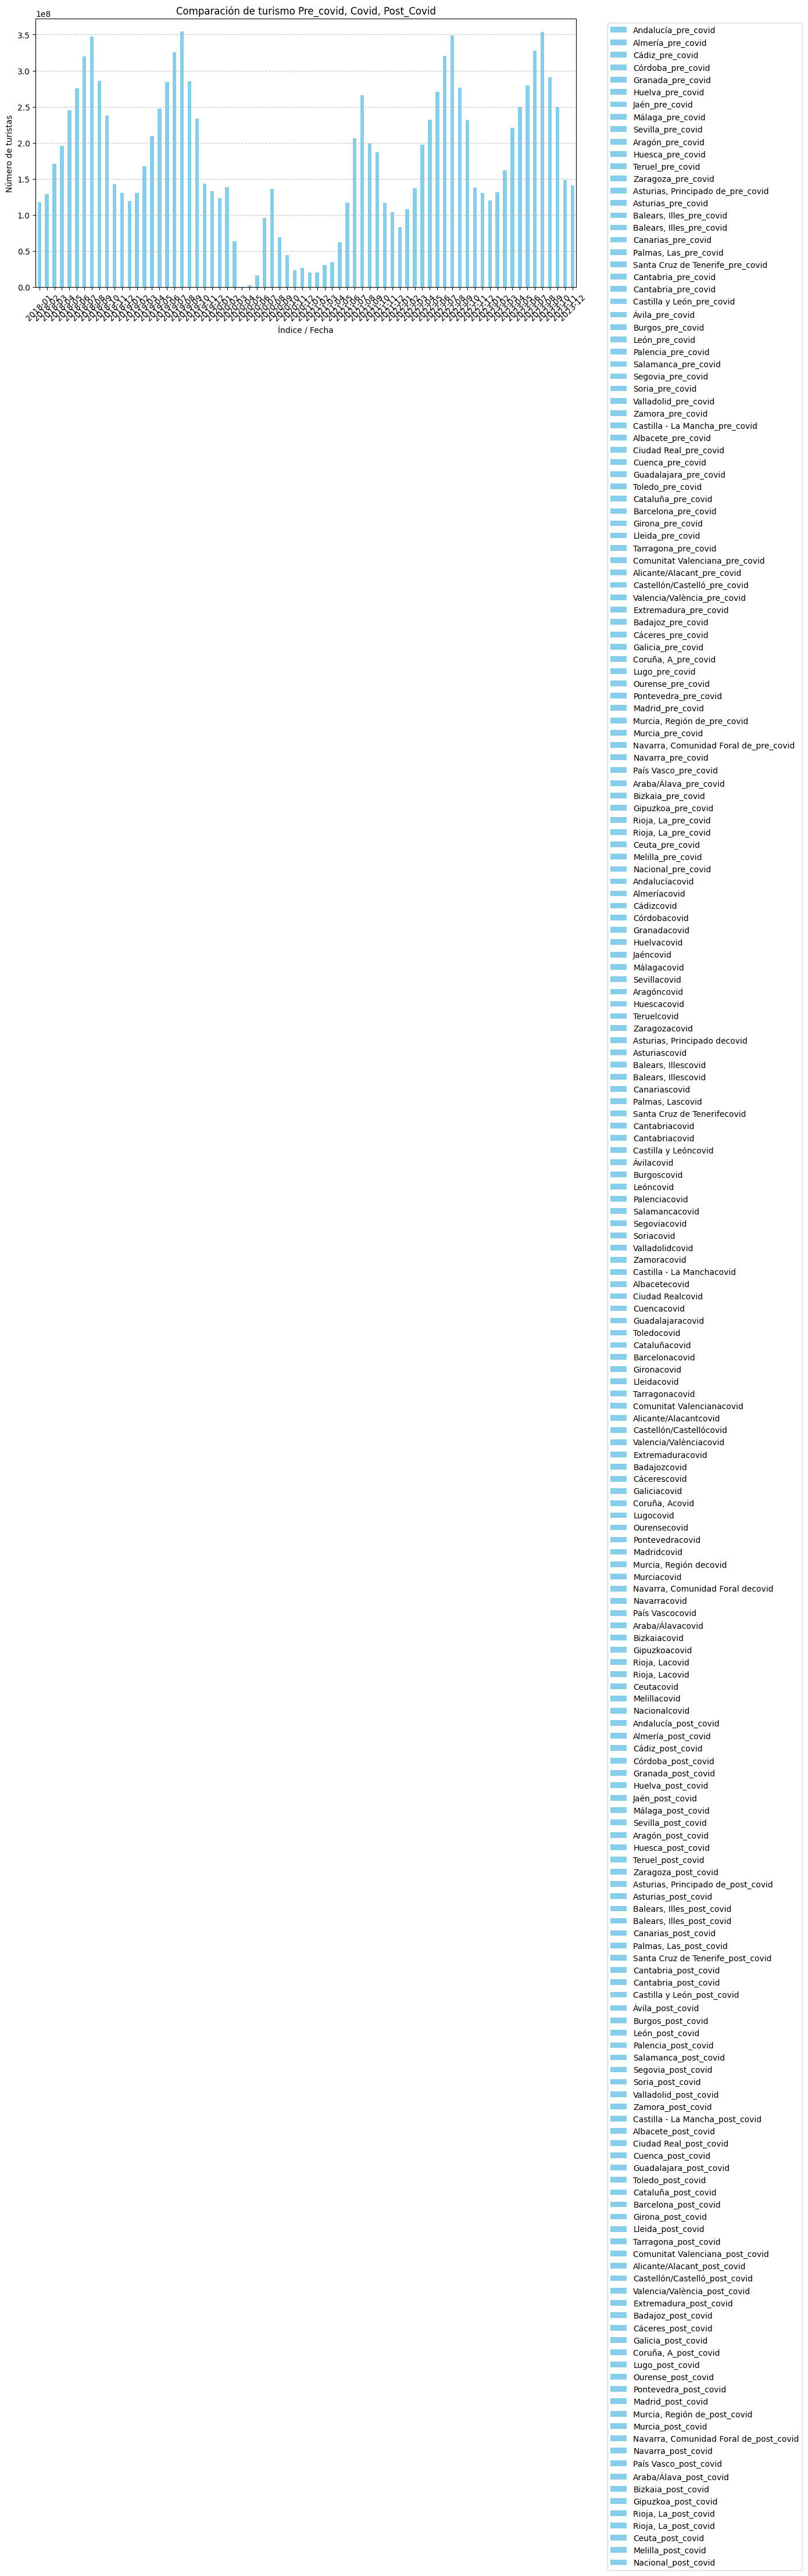

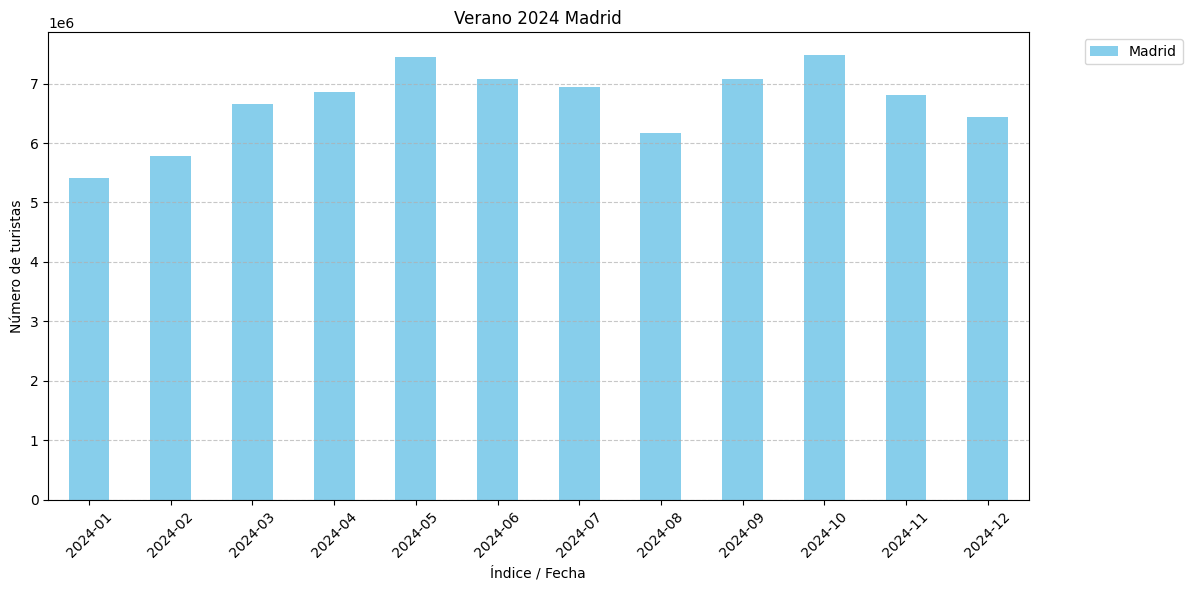

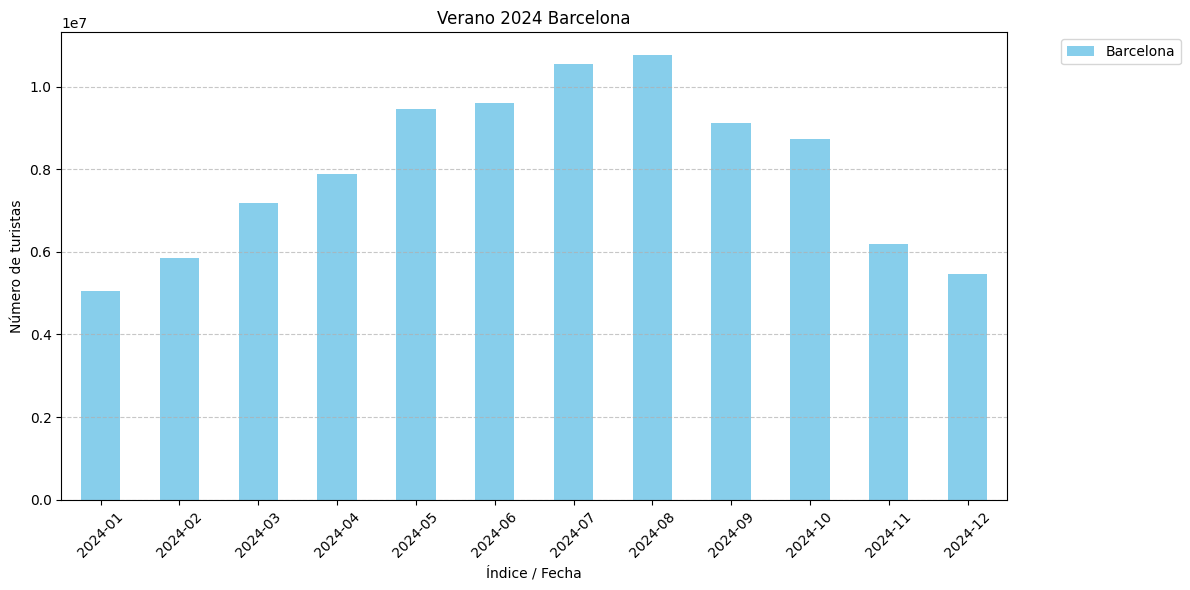

/var/folders/_8/pg7m38n54nbc5mpbtzttwghh0000gn/T/ipykernel_6283/1457934573.py:175: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico


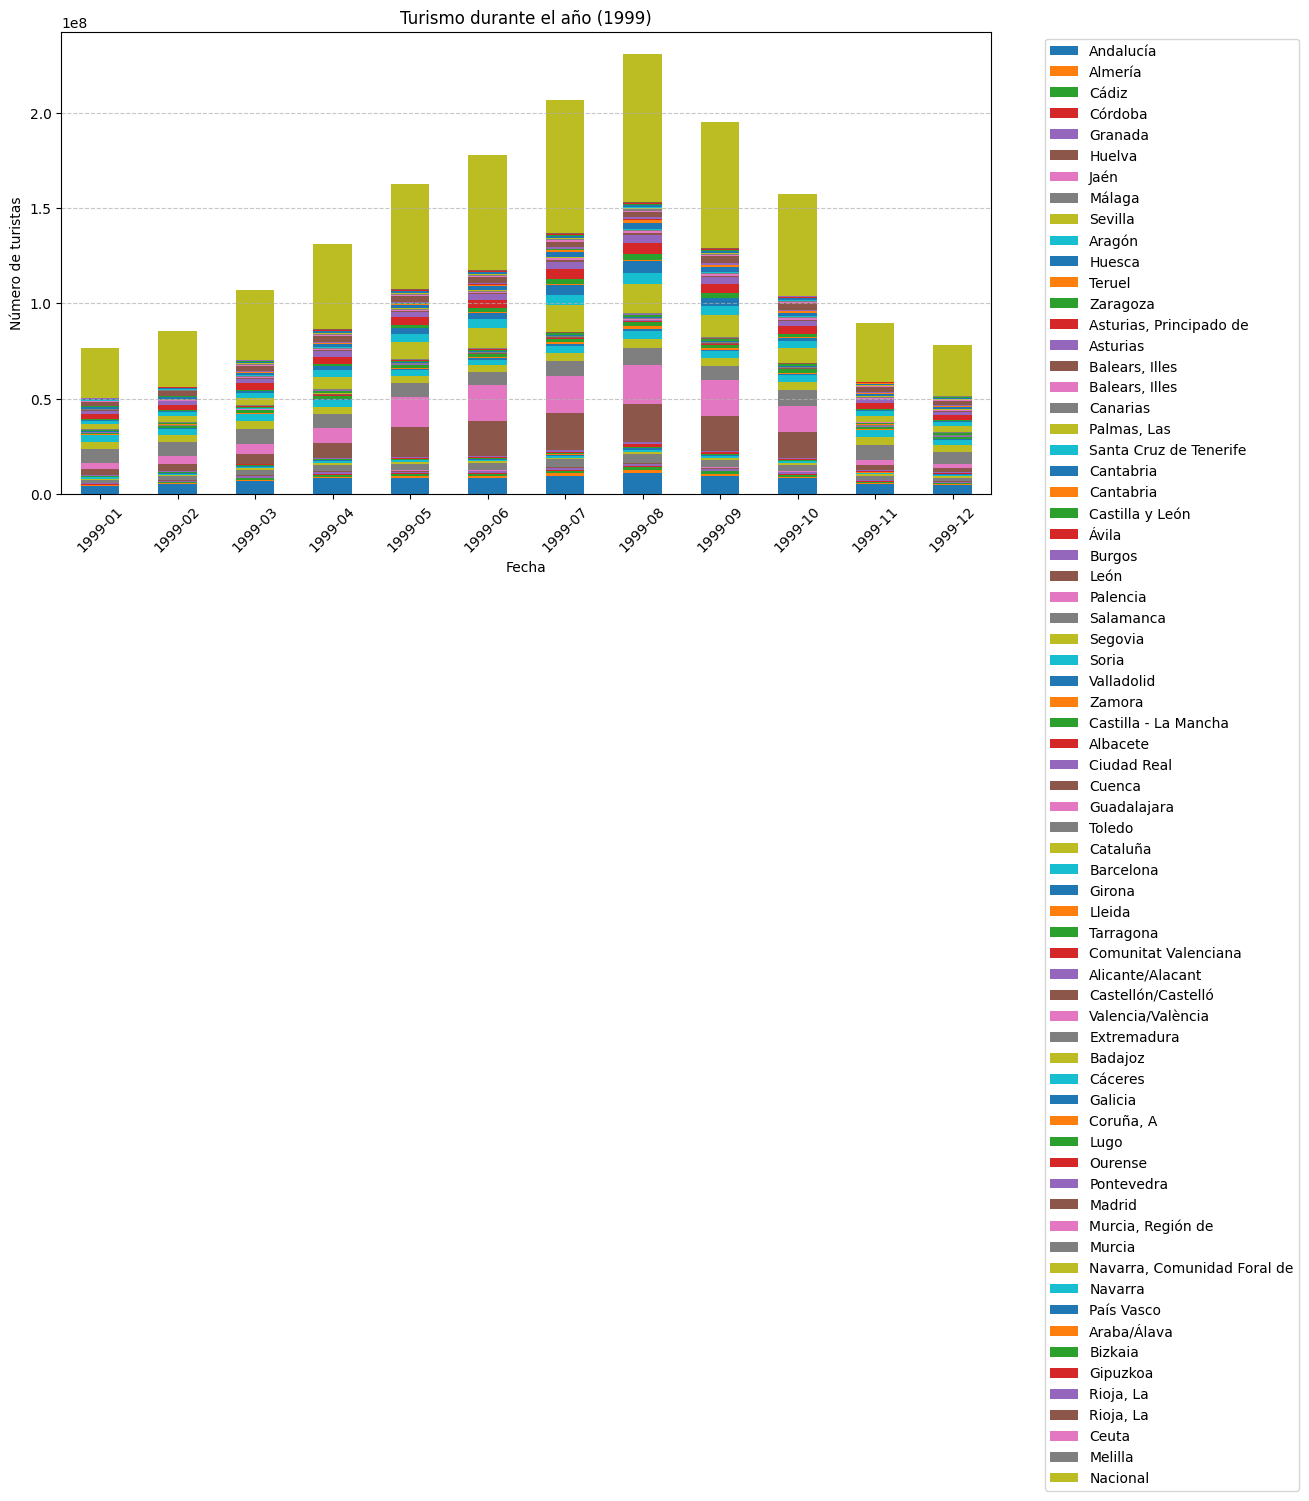

/var/folders/_8/pg7m38n54nbc5mpbtzttwghh0000gn/T/ipykernel_6283/1457934573.py:184: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico


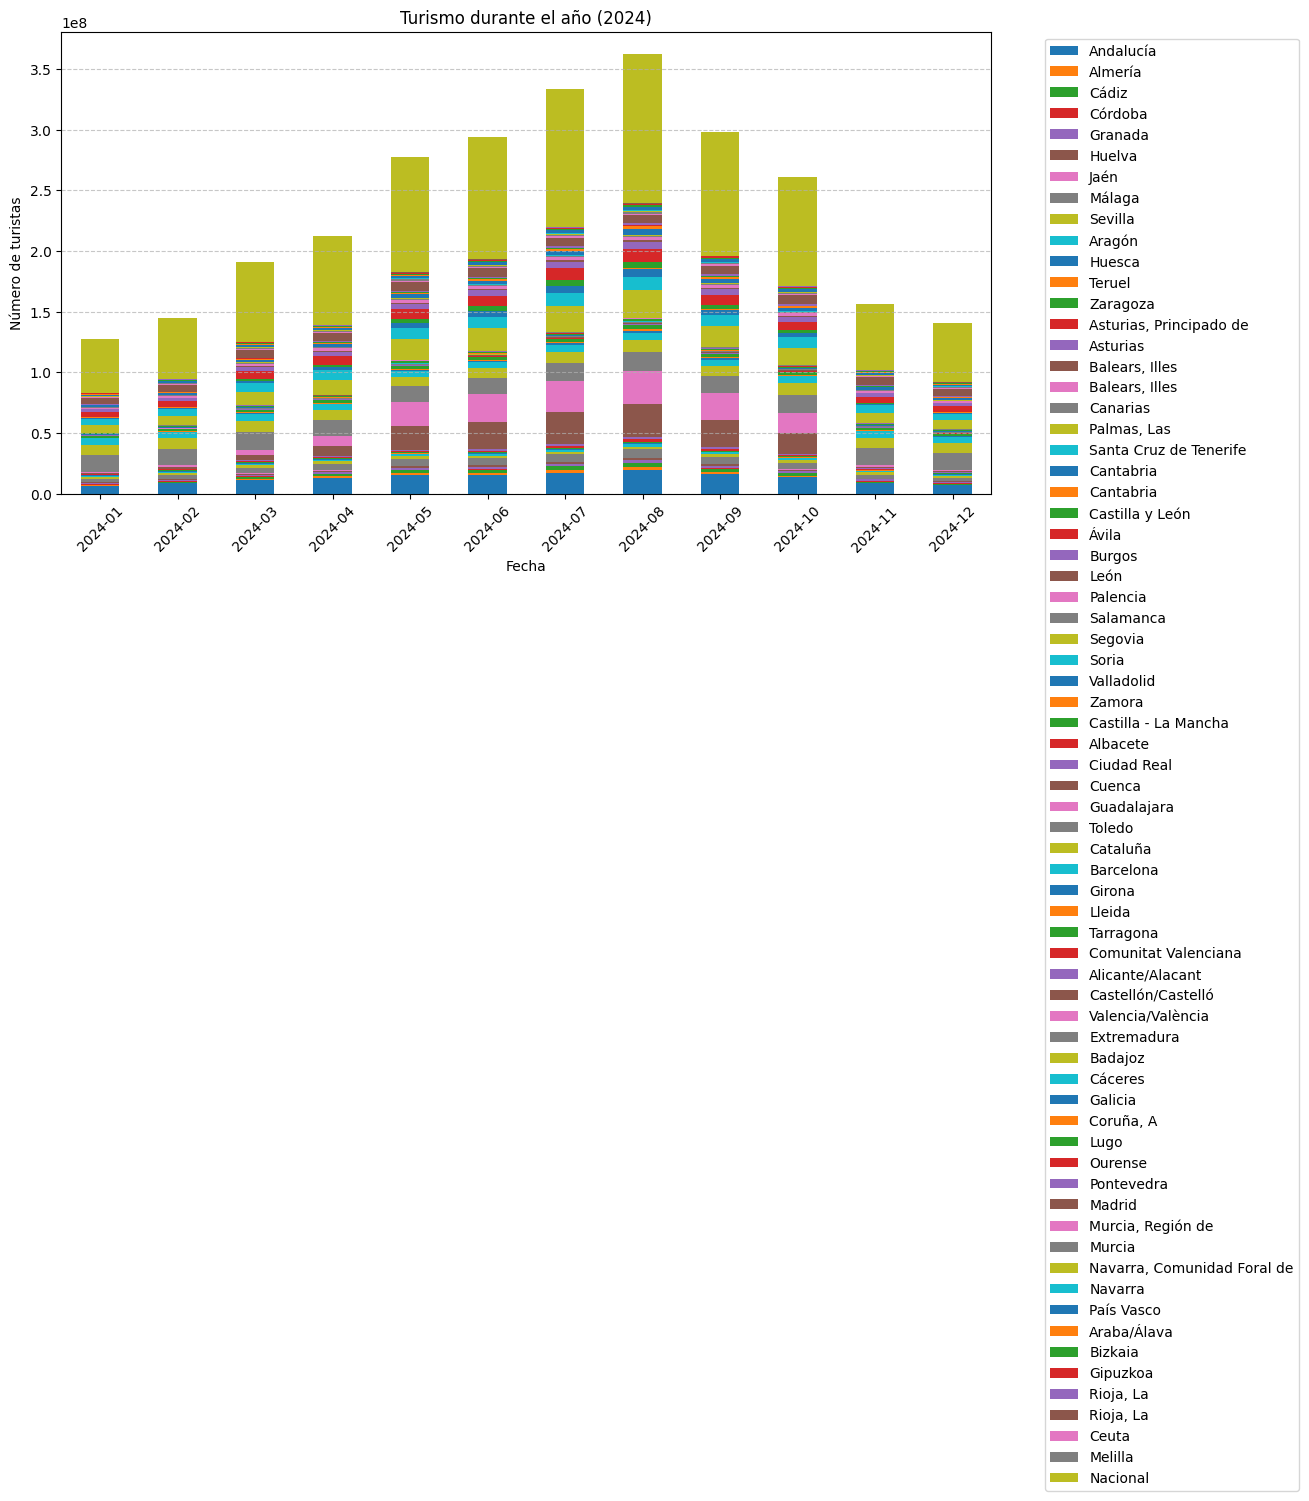

/var/folders/_8/pg7m38n54nbc5mpbtzttwghh0000gn/T/ipykernel_6283/1457934573.py:196: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico


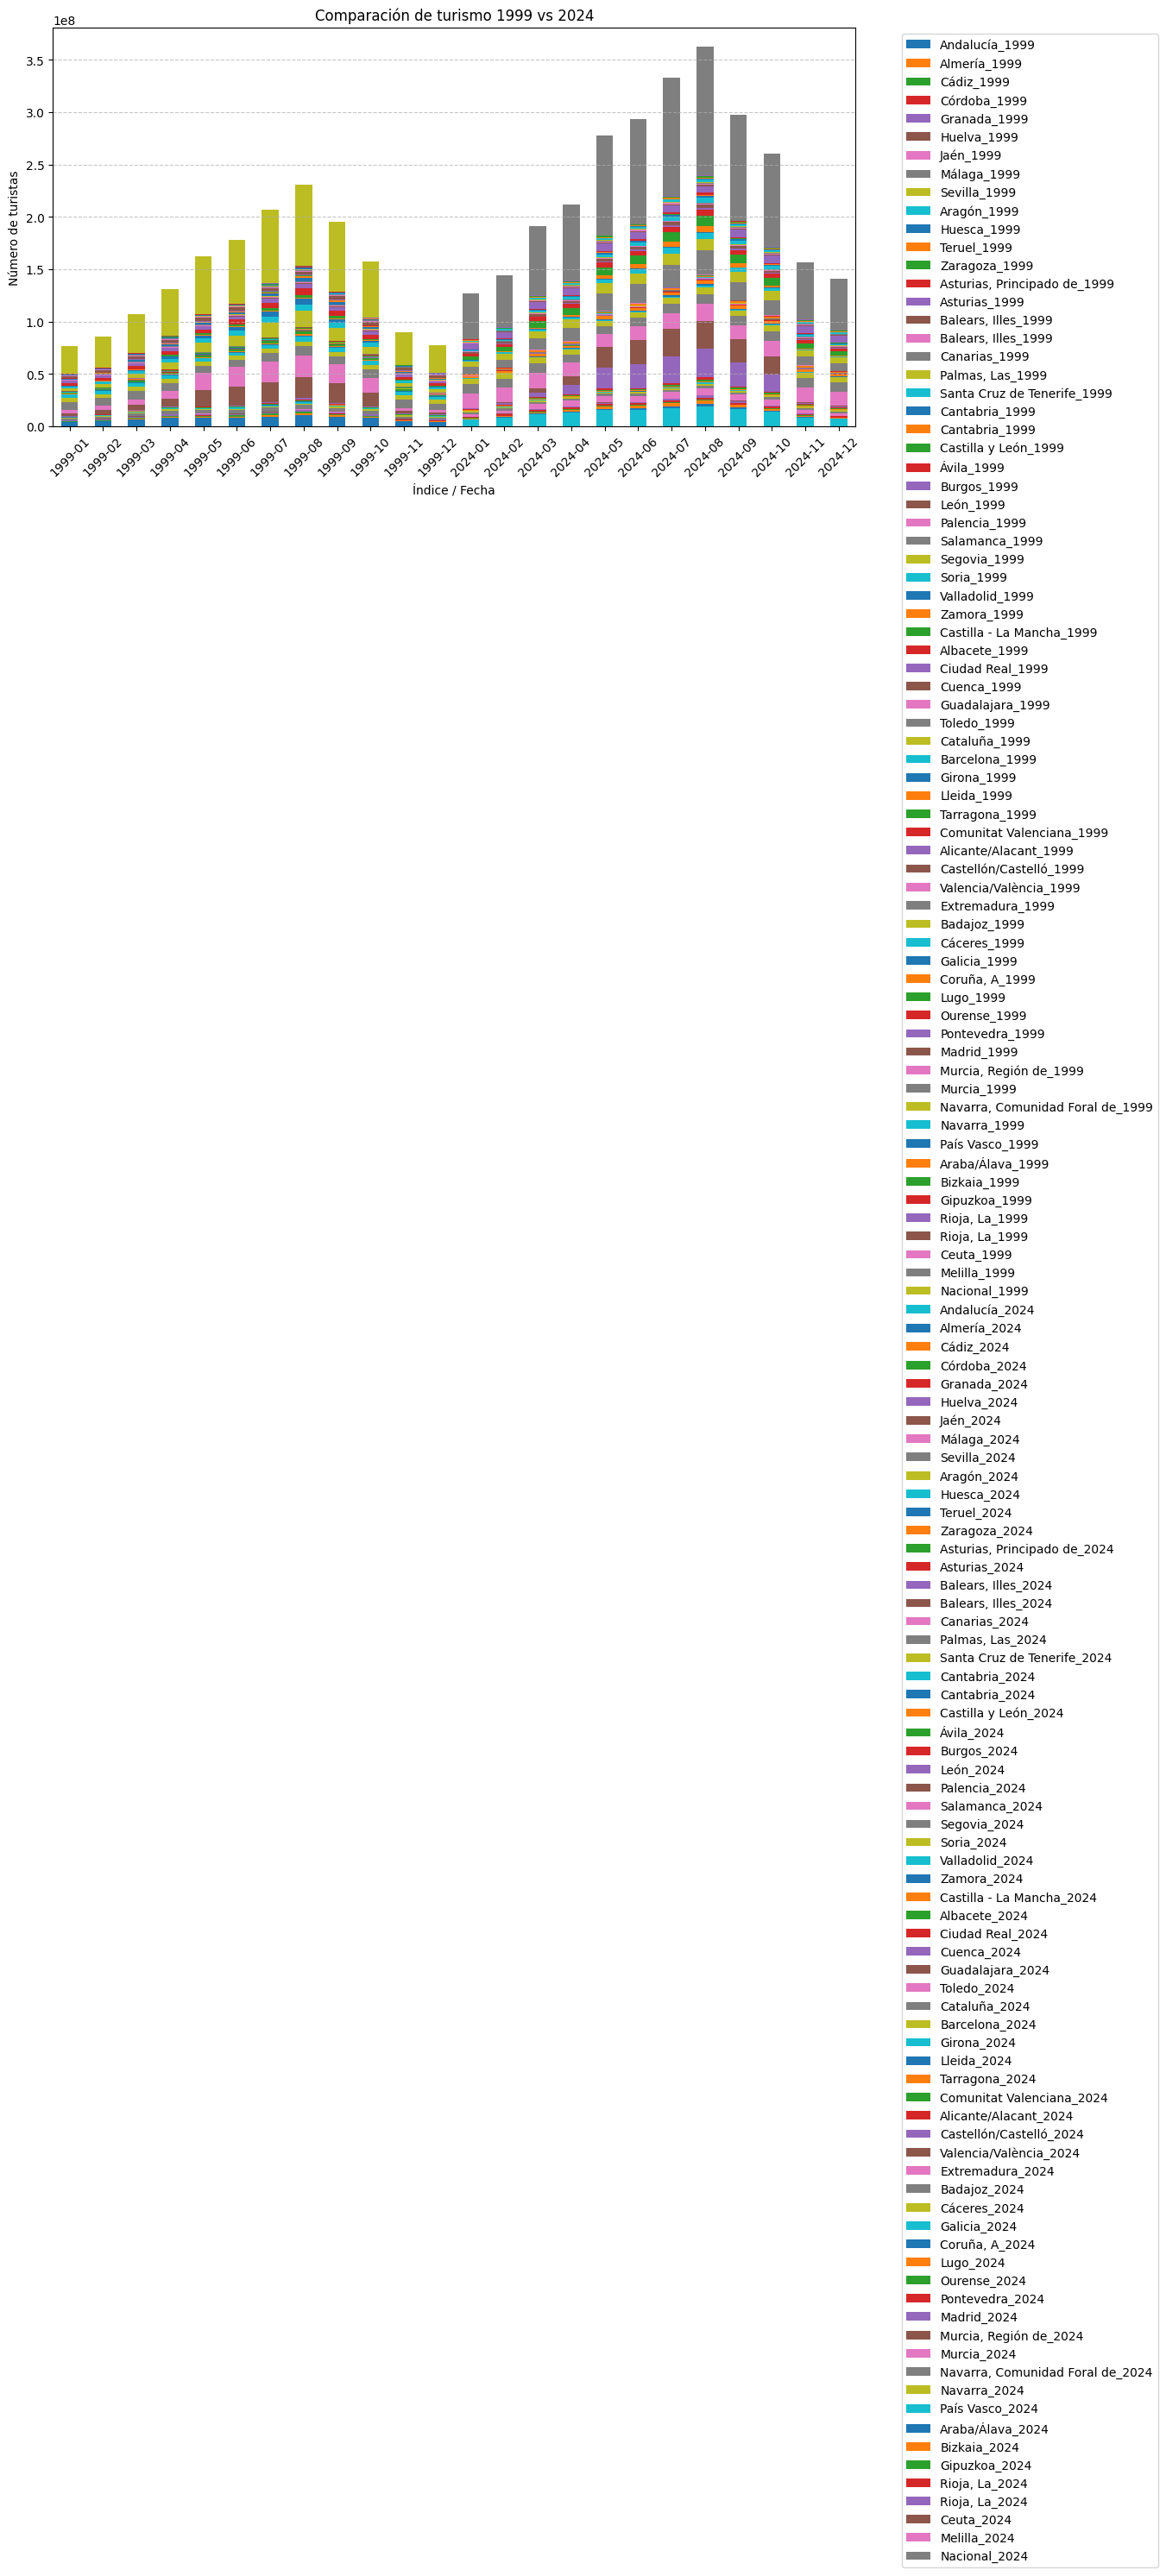

In [1]:
#                                                   EDA
#                                            TURISMO EN ESPAÑA
#**********************************************************************************************************************

#Librerias utilizadas
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
# plt.rcParams['axes.formatter.useoffset'] = False  # Desactiva el uso de desplazamiento
# plt.rcParams['axes.formatter.use_locale'] = False  # Asegura que los números sean claros
# plt.rcParams['axes.formatter.limits'] = (-10, 10)  # Evita notación científica en un rango amplio

#**********************************************************************************************************************

#Importacion de archivos 
turismo = pd.read_excel("./src/data/tourism_dataset.xlsx")
tipologia = pd.read_excel("./src/data/tipologia_viaje.xlsx")
motivo = pd.read_excel("./src/data/motivo_viaje.xlsx")
pais = pd.read_excel("./src/data/Gasto_segun_paisxlsx.xlsx")
sector = pd.read_excel("./src/data/Gasto_por_sector.xlsx")

#**********************************************************************************************************************

#Transformacion de archivos a DataFrame
turismo = pd.DataFrame(turismo)
tipologia = pd.DataFrame(tipologia)
motivo = pd.DataFrame(motivo)
pais = pd.DataFrame(pais)
sector = pd.DataFrame(sector)

#**********************************************************************************************************************

#Asignacion de indices
tipologia = tipologia.set_index(tipologia.columns[0])
motivo = motivo.set_index(motivo.columns[0])
pais = pais.set_index(pais.columns[0])
sector = sector.set_index(sector.columns[0])

#*******************************************HIPOTESIS PRINCIPAL*********************************************************
# ¿El turismo en España sigue una fuerte estacionalidad, con picos en verano y descensos en invierno?

#Indices Dataframe turismo (principal)
turismo = turismo.set_index(turismo.columns[0]).transpose()
turismo.index = turismo.index.astype(str)
turismo.index = turismo.index.str.replace("M", " ") #Reemplaza la M entre año y mes

turismo.index = turismo.index.str.replace(".5", "") #Reemplaza los numeros al final de las fechas
turismo.index = turismo.index.str.replace(".4", "")
turismo.index = turismo.index.str.replace(".3", "") 
turismo.index = turismo.index.str.replace(".2", "") 
turismo.index = turismo.index.str.replace(".1", "")

#Quitar numeros que forman parte del nombre de la comunidad autonoma del dataset principal "Turismo"
nombres_turismo = []
for columna in turismo.columns:
    if " " in columna:
        nombres_turismo.append(columna.split(" ", 1)[1])
    else:
        nombres_turismo.append(columna)

turismo.columns = nombres_turismo

#Elimina la comunidad de Madrid que esta duplicada
turismo.drop(["Madrid, Comunidad de"], axis=1, inplace=True)

nuevo_índice = pd.to_datetime(turismo.index, format='%Y %m').to_period('M') #Convierto a formato fecha quedandome solo con mes y año.
turismo.index = nuevo_índice

turismo = turismo.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int) #Paso las columnas (comntenido) a formato numerico ya que estaba en object y los nan los igualo a 0

def comunidades(turismo, comunidad): #Funcion que me permite identificar comunidades y unifica provincias
    comunidades_autonomas = {
        "Andalucía": ["Almería", "Cádiz", "Córdoba", "Granada", "Huelva", "Jaén", "Málaga", "Sevilla"],
        "Aragón": ["Huesca", "Teruel", "Zaragoza"],
        "Asturias": ["Asturias"],
        "Balears, Illes": ["Balears, Illes"],
        "Canarias": ["Palmas, Las", "Santa Cruz de Tenerife"],
        "Cantabria": ["Cantabria"],
        "Castilla y León": ["Ávila", "Burgos", "León", "Palencia", "Salamanca", "Segovia", "Soria", "Valladolid", "Zamora"],
        "Castilla - La Mancha": ["Albacete", "Ciudad Real", "Cuenca", "Guadalajara", "Toledo"],
        "Cataluña": ["Barcelona", "Girona", "Lleida", "Tarragona"],
        "Comunitat Valenciana": ["Alicante/Alacant", "Castellón/Castelló", "Valencia/València"],
        "Extremadura": ["Badajoz", "Cáceres"],
        "Galicia": ["Coruña, A", "Lugo", "Ourense", "Pontevedra"],
        "Madrid": ["Madrid"],
        "Murcia": ["Murcia"],
        "Navarra": ["Navarra"],
        "País Vasco": ["Araba/Álava", "Bizkaia", "Gipuzkoa"],
        "Rioja, La": ["Rioja, La"],
        "Ceuta": ["Ceuta"],
        "Melilla": ["Melilla"]
    }
    provincias = comunidades_autonomas.get(comunidad, [])
    if provincias:
        return turismo.loc[:, turismo.columns.intersection(provincias)]
    else:
        print(f"La comunidad '{comunidad}' no existe.")
        return None
    
def filtrar_rango_temporadas(turismo, rango_años, temporadas):
    estaciones = {
        'invierno': [12, 1, 2],
        'primavera': [3, 4, 5],
        'verano': [6, 7, 8],
        'otoño': [9, 10, 11]
    }
   
    meses = sum([estaciones[t] for t in temporadas], [])
    inicio, fin = rango_años
    
    filtro = (turismo.index.year >= inicio) & (turismo.index.year <= fin) & (turismo.index.month.isin(meses))
    return turismo[filtro]

turismo = turismo.groupby(turismo.index).sum() #Suma los duplicados y los vuelve uno

#Comparacion PRE, COVID, POST
resultado_post_covid = filtrar_rango_temporadas(turismo, (2022, 2023), ['primavera', 'verano', "otoño", "invierno"])
covid=filtrar_rango_temporadas(turismo, (2020, 2021), ['primavera', 'verano', "otoño", "invierno"])
resultado_pre_covid = filtrar_rango_temporadas(turismo, (2018, 2019), ['primavera', 'verano', "otoño", "invierno"])
resultado_covid = pd.concat([resultado_pre_covid.add_suffix('_pre_covid'),covid.add_suffix("covid"), resultado_post_covid.add_suffix('_post_covid')], axis=1)

resultado_covid.plot(kind='bar', stacked=True, figsize=(12, 6), color='skyblue')
plt.title("Comparación de turismo Pre_covid, Covid, Post_Covid")
plt.xlabel("Índice / Fecha")
plt.ylabel("Número de turistas")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas de guía en el eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Mover la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico
plt.show()




# Comparacion Madrid Barcelona
madrid2024 = filtrar_rango_temporadas(turismo["Madrid"], (2024, 2024), ['primavera', 'verano', "otoño", "invierno"])
barcelona2024 = filtrar_rango_temporadas(turismo["Barcelona"], (2024, 2024), ['primavera', 'verano', "otoño", "invierno"])

madrid2024.plot(kind='bar', stacked=True, figsize=(12, 6), color='skyblue')
plt.title("Verano 2024 Madrid")
plt.xlabel("Índice / Fecha")
plt.ylabel("Número de turistas")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas de guía en el eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Mover la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico
plt.show()

barcelona2024.plot(kind='bar', stacked=True, figsize=(12, 6), color='skyblue')
plt.title("Verano 2024 Barcelona")
plt.xlabel("Índice / Fecha")
plt.ylabel("Número de turistas")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas de guía en el eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Mover la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico
plt.show()





# Comparacion 1999 vs 2024 Nacional
año1999 = filtrar_rango_temporadas(turismo, (1999, 1999), ['primavera', 'verano', "otoño", "invierno"])
año2024 = filtrar_rango_temporadas(turismo, (2024, 2024), ['primavera', 'verano', "otoño", "invierno"])

año1999.plot(kind='bar', stacked=True, figsize=(12, 6), title="Turismo durante el año (1999)")
plt.xlabel("Fecha")
plt.ylabel("Número de turistas")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas de guía en el eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Mover la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico
plt.show()

año2024.plot(kind='bar', stacked=True, figsize=(12, 6), title="Turismo durante el año (2024)")
plt.xlabel("Fecha")
plt.ylabel("Número de turistas")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas de guía en el eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Mover la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico
plt.show()

df_combinado = pd.concat([año1999.add_suffix('_1999'), año2024.add_suffix('_2024')], axis=1)

df_combinado.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Comparación de turismo 1999 vs 2024")
plt.xlabel("Índice / Fecha")
plt.ylabel("Número de turistas")
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas de guía en el eje Y
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Mover la leyenda fuera del gráfico
plt.tight_layout()  # Ajustar automáticamente la disposición del gráfico
plt.show()

In [193]:
turismo

,Andalucía,Almería,Cádiz,Córdoba,Granada,Huelva,Jaén,Málaga,Sevilla,Aragón,...,Navarra,País Vasco,Araba/Álava,Bizkaia,Gipuzkoa,"Rioja, La","Rioja, La",Ceuta,Melilla,Nacional
1999-01,3991668,425040,349420,189008,618896,134510,121640,1545668,607492,640374,...,142730,461896,98966,194418,168508,83684,83684,55990,18044,26363810
1999-02,4899848,542326,486818,221708,770368,221026,152070,1827946,677586,708686,...,158784,518258,98980,218332,200948,115382,115382,42620,23544,29313984
1999-03,6673762,690876,722626,335992,950464,303492,204864,2473006,992438,831752,...,223710,631152,117790,247166,266198,162986,162986,47880,26226,36710911
1999-04,8183434,721208,949466,443906,1110586,374764,226036,3176204,1181266,820608,...,279850,737928,126428,283712,327786,178006,178006,45040,26310,44808366
1999-05,8337698,829360,1057760,447782,998632,342452,200678,3251670,1209360,786592,...,289016,749994,127376,293436,329180,196042,196042,45754,28516,55382166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10,13927238,833613,2001348,619211,1656018,630990,319420,5586313,2280326,1558274,...,582480,2065093,261370,921829,881896,314691,314691,27206,35158,89434037
2024-11,8762174,342424,962881,534322,1291801,315556,273390,3116451,1925347,1199555,...,454306,1625503,229213,732916,663372,242372,242372,28918,30362,54452836
2024-12,7231362,327937,754189,453027,1140273,208943,229449,2368972,1748573,1173352,...,380250,1445317,230906,639204,575208,191812,191812,29886,26394,49173353
2025-01,6518195,255804,651312,418254,1120306,153693,182191,2224498,1512140,1076330,...,269482,1193028,184350,497102,511574,159093,159093,27451,23830,45373746
